In [52]:
from mistralai.client import MistralClient, ChatMessage
import faiss

import requests
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

load_dotenv()

True

Today's date: 2024-02-26


In [57]:
api_key = os.environ['API_KEY']

In [14]:
# Basic example

model = "mistral-small"

client = MistralClient(api_key=api_key)

messages = [
    ChatMessage(role="user", content="Nazi are they really bad?"),
]

# No streaming
chat_response = client.chat(
    model=model,
    messages=messages,
)

print(chat_response.choices[0].message.content)

Yes, the Nazi regime, which was in power in Germany from 1933 to 1945, is widely considered to have been one of the most evil and brutal regimes in history. Under the leadership of Adolf Hitler, the Nazis implemented policies of racial discrimination and persecution, which led to the genocide of six million Jews during the Holocaust. They also persecuted and murdered other groups that they deemed inferior or undesirable, including Romani people, homosexuals, people with disabilities, and political dissidents. The Nazi regime was responsible for numerous war crimes and crimes against humanity, and its actions had a profound and devastating impact on the world.


What is RAG (Retrieval-Augmented Generation) ?

- Step 1 : Retrieve relevant information from a knowledge base with text embeddings stored in a vector store
- Step 2 : Insert the relevant information to the prompt for the LLM to generate information

##### Basic Rag

In [15]:
response = requests.get('https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt')
text = response.text

In [18]:
chunk_size = 2048
chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

print("There are {} chunks and {} characters".format(len(chunks), len(text)))

There are 37 chunks and 75014 characters


We must consider the trade-offs that come with using smaller chunks, such as increasing processing time and computational resources.

In [20]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    return embeddings_batch_response.data[0].embedding

text_embeddings = np.array([get_text_embedding(chunk) for chunk in chunks])

Once we get the text embeddings, a common practice is to store them in a vector database for efficient processing and retrieval. We are using an open-source vector database Faiss (Facebook AI Similarity Search), which allows for efficient similarity search.

Check this [Medium article](https://lajavaness.medium.com/indexation-et-recherche-avec-faiss-c7675c42abb9) for more details on Faiss.

In [26]:
d = text_embeddings.shape[1] 
index = faiss.IndexFlatL2(d) # We create a Flat index (exhaustive search) : this can be costly for large datasets
index.add(text_embeddings)

In [28]:
question = "Is it possible to make a lot of money and stay true to your values?"
question_embeddings = np.array([get_text_embedding(question)])

Note that since Mistral AI embeddings are norm 1, cosine similarity, dot product or Euclidean distance are all equivalent

In [45]:
distances, indices = index.search(question_embeddings, k=5) # k is the number of nearest neighbors to return
retrieved_chunk = [chunks[i] for i in indices.tolist()[0]]

In [46]:
print("The retrieved chunks are: ", retrieved_chunk[0])

The retrieved chunks are:   But by this point I knew enough to find that encouraging instead of discouraging.

One of the most conspicuous patterns I've noticed in my life is how well it has worked, for me at least, to work on things that weren't prestigious. Still life has always been the least prestigious form of painting. Viaweb and Y Combinator both seemed lame when we started them. I still get the glassy eye from strangers when they ask what I'm writing, and I explain that it's an essay I'm going to publish on my web site. Even Lisp, though prestigious intellectually in something like the way Latin is, also seems about as hip.

It's not that unprestigious types of work are good per se. But when you find yourself drawn to some kind of work despite its current lack of prestige, it's a sign both that there's something real to be discovered there, and that you have the right kind of motives. Impure motives are a big danger for the ambitious. If anything is going to lead you astray, it

In [47]:
print("Their embeddings are: ", text_embeddings[indices[0]])

Their embeddings are:  [[-0.06359863  0.06427002  0.02284241 ... -0.01721191 -0.01486206
  -0.01552582]
 [-0.06787109  0.03765869  0.04403687 ... -0.01507568 -0.00759506
   0.00488663]
 [-0.03970337  0.05783081  0.01531982 ... -0.03805542 -0.0112381
  -0.0096817 ]
 [-0.07196045  0.04748535  0.02894592 ... -0.03182983 -0.01559448
  -0.01236725]
 [-0.05993652  0.06396484  0.03674316 ... -0.01660156  0.00315666
  -0.00465775]]


Here, we are using a simple similarity search with embeddings, there are also other statistical retrieval methods like `TF-IDF` and `BM25` that use frequency and distribution of terms in the document to identify relevant text chunks.

In [48]:
prompt = f"""
Context information is below.
---------------------
{retrieved_chunk}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {question}
Answer:
"""

In [49]:
def run_mistral(user_message, model="mistral-medium"):
    messages = [
        ChatMessage(role="user", content=user_message)
    ]
    chat_response = client.chat(
        model=model,
        messages=messages
    )
    return (chat_response.choices[0].message.content)

In [50]:
run_mistral(prompt)

"Based on the context, the author suggests that it is possible to make a lot of money and stay true to your values. They discuss their own experience of becoming rich through founding a startup, which allowed them to pursue their passion for painting. The author also notes that working on unprestigious projects can be a sign of having the right kind of motives, and that the desire to impress people can be a danger for the ambitious. However, it's worth noting that the context does not explicitly address the question of whether making a lot of money always aligns with one's values, and further information would be needed to answer this question fully."

Check Corrective Rag (CRAG) to correct irrelevancy in retrieve documents.

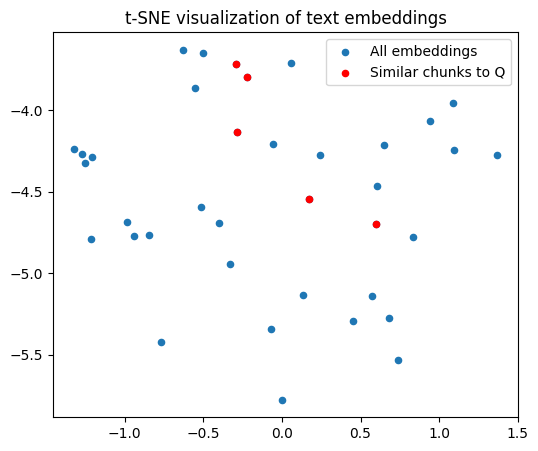

In [56]:
# Réduire la dimensionnalité de tous les embeddings avec t-SNE
tsne = TSNE(n_components=2, random_state=0)
text_embeddings_2d = tsne.fit_transform(text_embeddings)

# Sélectionner les embeddings à colorer
selected_embeddings_2d = text_embeddings_2d[indices[0]]

# Visualiser tous les embeddings
plt.figure(figsize=(6, 5))
plt.scatter(text_embeddings_2d[:, 0], text_embeddings_2d[:, 1], s=20)

# Visualiser et colorer les embeddings sélectionnés
plt.scatter(selected_embeddings_2d[:, 0], selected_embeddings_2d[:, 1], s=20, color='red')
plt.legend(["All embeddings", "Similar chunks to Q"], loc="best")
plt.title('t-SNE visualization of text embeddings')
plt.show()